## Attempt to fit Bitcoin Prices from Coindesk's API to a Log Periodic Power Law Singularity explained here
https://arxiv.org/pdf/1803.05663.pdf
https://pypi.org/project/lppls/


In [1]:
import pandas as pd
import numpy as np
from lppls import lppls, data_loader, lppls_cmaes
import requests
import json
import datetime
pd.set_option('display.max_rows', 5)
import pathlib
import os
pathlib.Path().absolute()
%matplotlib inline

In [2]:
start = "2011-06-01"
end = "2021-05-16"
s = 1438387200 # 2015-08-01
#s = 1620950400
e = 1621123200 # 2021-05-16

CURRENCY = "BTC"
CURRENCY_PAIR = "USDT_ETH"
FILENAME = os.path.join(os.getcwd(), "data\\ADA_USD_2018-05-31_2021-05-16-CoinDesk.csv").replace("\\", "/")
DOGE_FILENAME = os.path.join(os.getcwd(), "data\\DOGE_USD_2019-02-27_2021-05-16-CoinDesk.csv").replace("\\", "/")
MAX_SEARCHES = 25

In [3]:
date_ranges = {"2012-05-25": "2012-08-18",
               "2013-01-03": "2013-04-11",
               "2013-10-07": "2013-11-23",
               "2015-06-08": "2017-12-18",
               "2017-03-31": "2017-12-18" 
              }

In [4]:
starts = ["2012-05-25", "2013-01-03", "2013-10-07", "2015-06-08", "2017-03-31", "2017-12-18"]
ends = ["2012-08-18", "2013-04-11", "2013-11-23", "2017-12-18", "2017-12-18", "2021-05-16"]

In [5]:
def graph_lppl_model(start, end, currency):
    if currency == "BTC":
        response = requests.get(f"https://api.coindesk.com/v1/bpi/historical/close.json?start={start}&end={end}")
        json_data = response.json() if response and response.status_code == 200 else None

        df = pd.DataFrame.from_dict(json_data['bpi'].items())
        df.columns = ["Date", "Close"]
        
    elif currency == "USDT_ETH":
        response = requests.get(f"https://poloniex.com/public?command=returnChartData&currencyPair={currency}&start={s}&end={e}&period=86400")
        json_data = response.json() if response and response.status_code == 200 else None
        df = pd.DataFrame.from_dict(json_data)
        df['date'] = pd.to_datetime(df['date'], unit='s')
        df = df[['date', 'close']].copy()
        df.columns = ["Date", "Close"]

    time = np.linspace(0, len(df)-1, len(df))
    price = np.log(df['Close'].values)
    observations = np.array([time, price])

    lppls_model = lppls.LPPLS(observations=observations)
    tc, m, w, a, b, c, c1, c2 = lppls_model.fit(observations, MAX_SEARCHES, minimizer='Nelder-Mead')
    lppls_model.plot_fit()
    print(f"{currency} prices from {start} to {end} FIT TO LPPLS")
    df.plot(figsize=(14, 8), x="Date", y="Close")

In [6]:
def graph_lppl_model_csv(filename):
    df = pd.read_csv(filename)
    currency = df['Currency'][0]
    start = df['Date'][0]
    df = df[['Date', "Closing Price (USD)"]]
    df.columns = ['Date', 'Close']
    
    time = np.linspace(0, len(df)-1, len(df))
    price = np.log(df['Close'].values)
    observations = np.array([time, price])

    lppls_model = lppls.LPPLS(observations=observations)
    tc, m, w, a, b, c, c1, c2 = lppls_model.fit(observations, MAX_SEARCHES, minimizer='Nelder-Mead')
    lppls_model.plot_fit()
    print(f"{currency} prices from {start} to {end} FIT TO LPPLS")
    df.plot(figsize=(14, 8), x="Date", y="Close")

DOGE prices from 2019-02-27 to 2021-05-16 FIT TO LPPLS


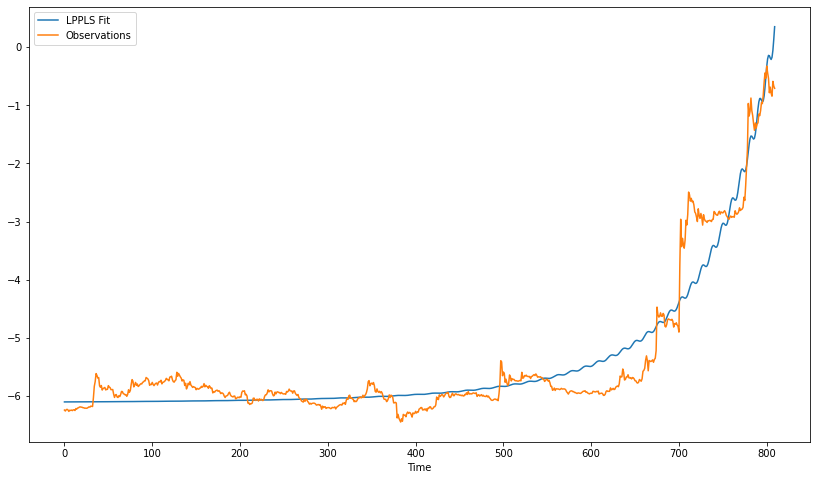

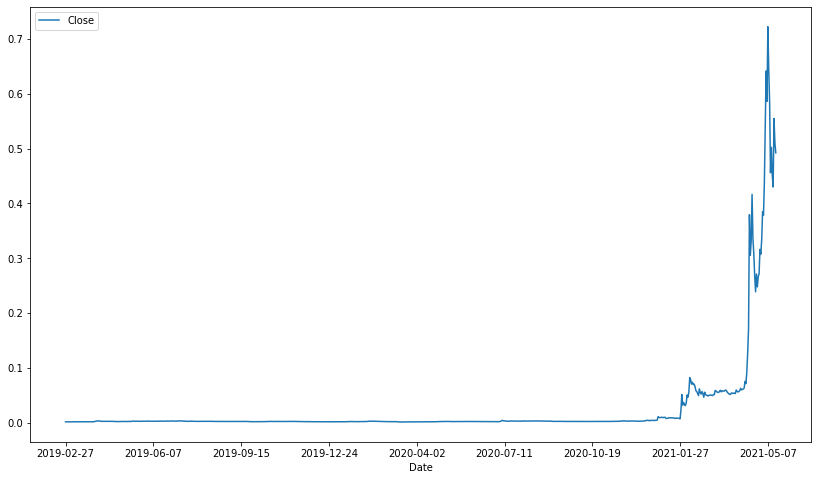

In [7]:
graph_lppl_model_csv(DOGE_FILENAME)

ADA prices from 2018-05-31 to 2021-05-16 FIT TO LPPLS


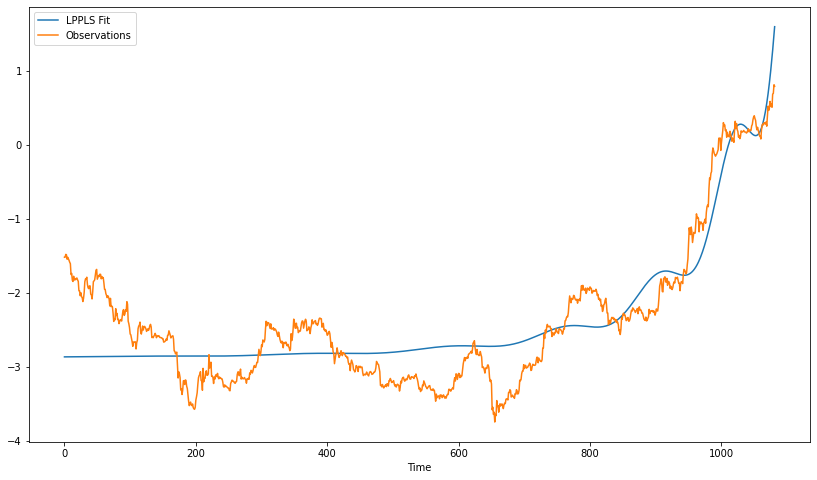

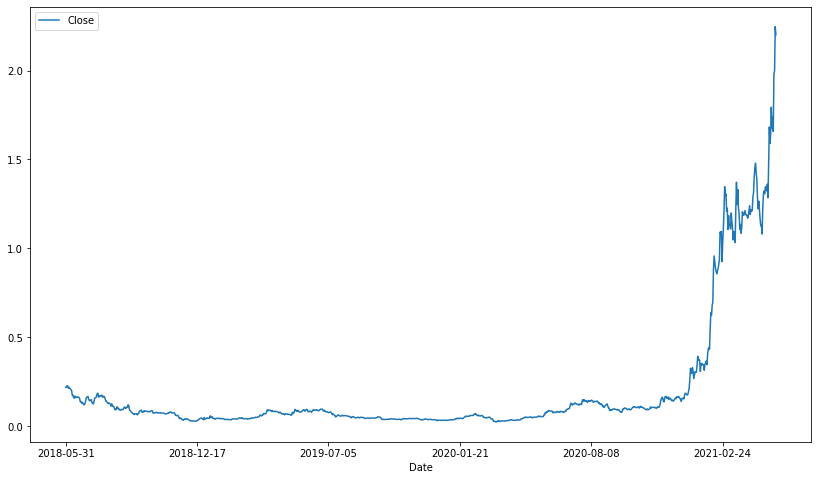

In [8]:
graph_lppl_model_csv(FILENAME)

USDT_ETH prices from 1438387200 to 1621123200 FIT TO LPPLS


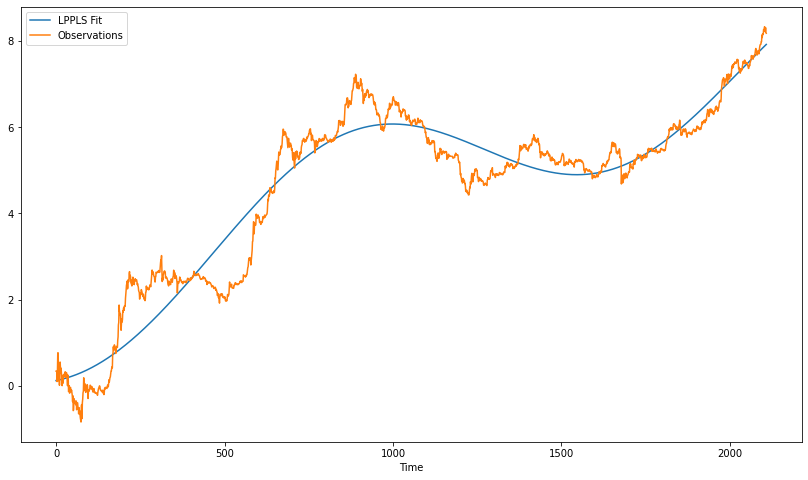

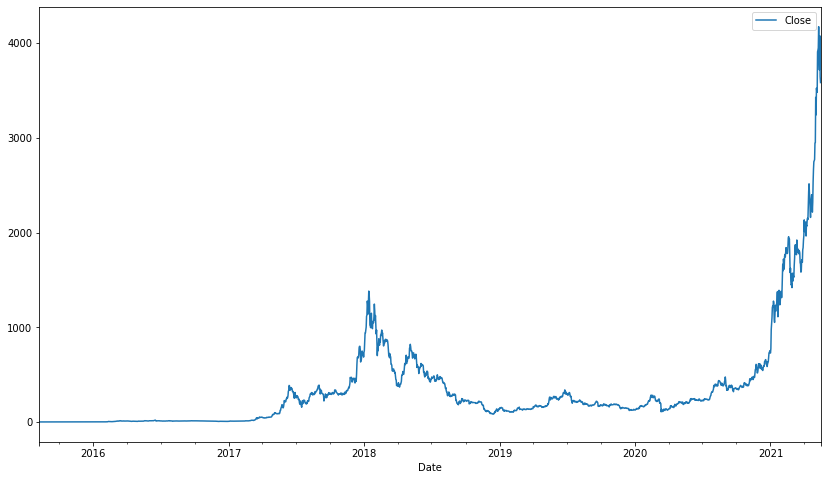

In [9]:
graph_lppl_model(s, e, CURRENCY_PAIR)

In [10]:
def graph_lppl_cmaes_model(start, end, currency):
    if currency == "BTC":
        response = requests.get(f"https://api.coindesk.com/v1/bpi/historical/close.json?start={start}&end={end}")
        json_data = response.json() if response and response.status_code == 200 else None

        df = pd.DataFrame.from_dict(json_data['bpi'].items())
        df.columns = ["Date", "Close"]

        time = np.linspace(0, len(df)-1, len(df))
        price = np.log(df['Close'].values)
        observations = np.array([time, price])

        lppls_model = lppls_cmaes.LPPLSCMAES(observations=observations)
        tc, m, w, a, b, c, c1, c2 = lppls_model.fit(max_iteration=2500, pop_size=4)
        lppls_model.plot_fit()
        print(f"{currency} prices from {start} to {end} FIT TO LPPLS CMA-ES")

(80_w,160)-aCMA-ES (mu_w=42.4,w_1=5%) in dimension 3 (seed=443081, Mon May 17 17:09:24 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    160 3.228322796641633e+02 1.0e+00 1.78e+00  2e-01  6e+02 0:00.1
    2    320 2.267688554458686e+02 2.0e+00 3.57e+00  5e-01  9e+02 0:00.2
    3    480 2.199063317082199e+02 3.8e+00 4.23e+00  3e-01  7e+02 0:00.4
   26   4160 2.188678618073868e+02 2.2e+01 3.28e+00  4e-06  2e-03 0:03.5
   40   6400 2.188678618056508e+02 1.8e+01 2.21e+00  8e-09  6e-06 0:05.3
BTC prices from 2011-06-01 to 2021-05-16 FIT TO LPPLS CMA-ES


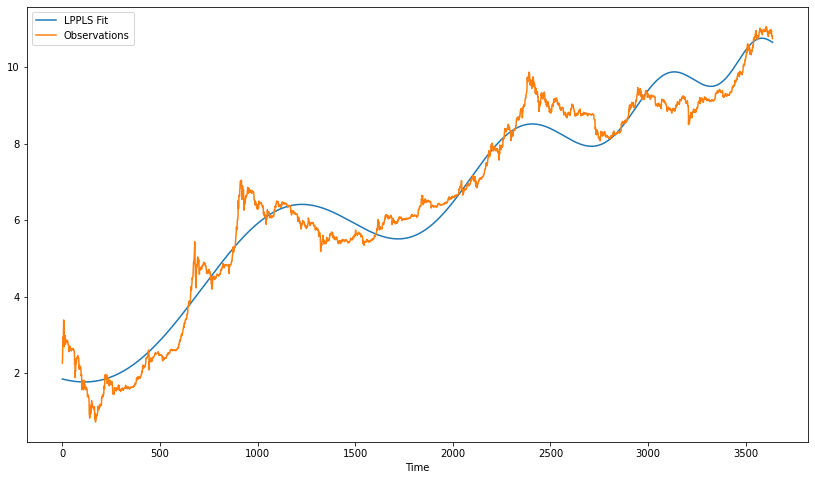

In [11]:
graph_lppl_cmaes_model(start, end, CURRENCY)

BTC prices from 2011-06-01 to 2021-05-16 FIT TO LPPLS


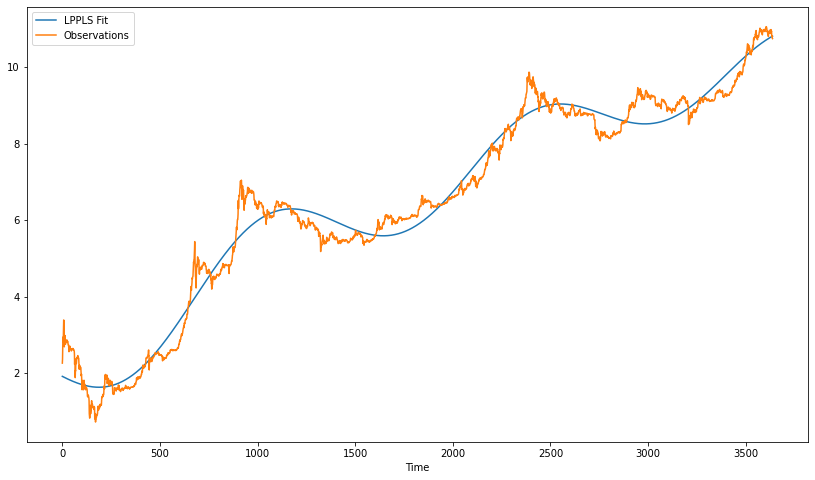

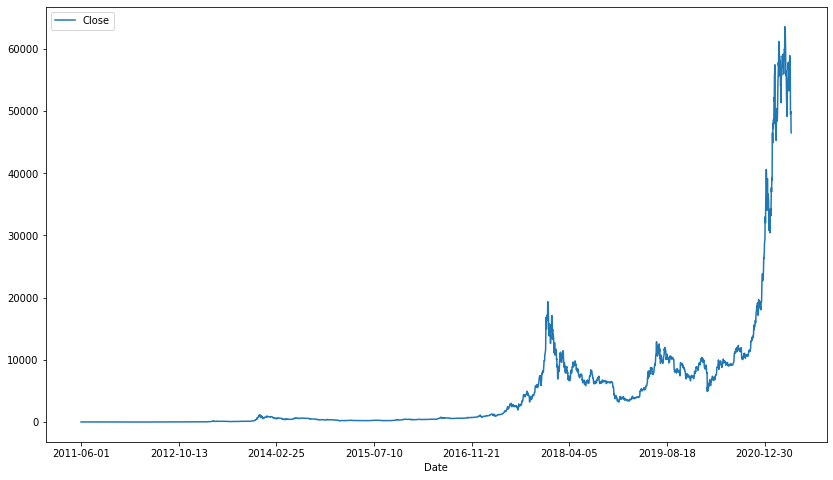

In [12]:
graph_lppl_model(start, end, CURRENCY)

BTC prices from 2012-05-25 to 2012-08-18 FIT TO LPPLS


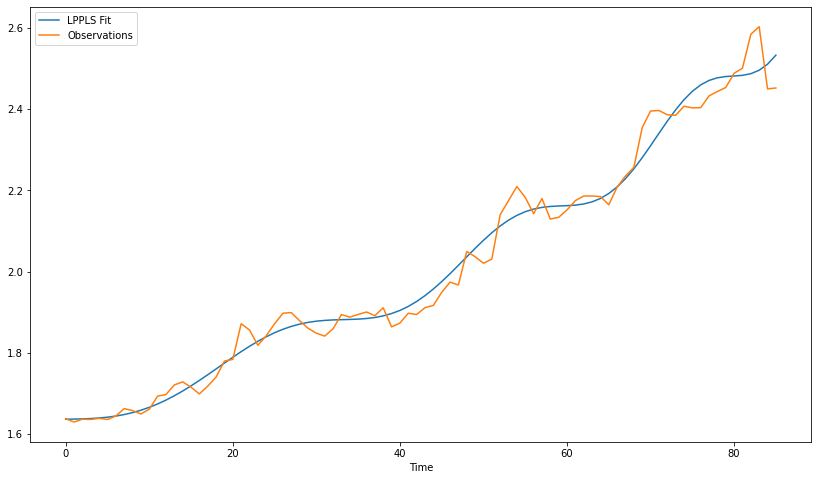

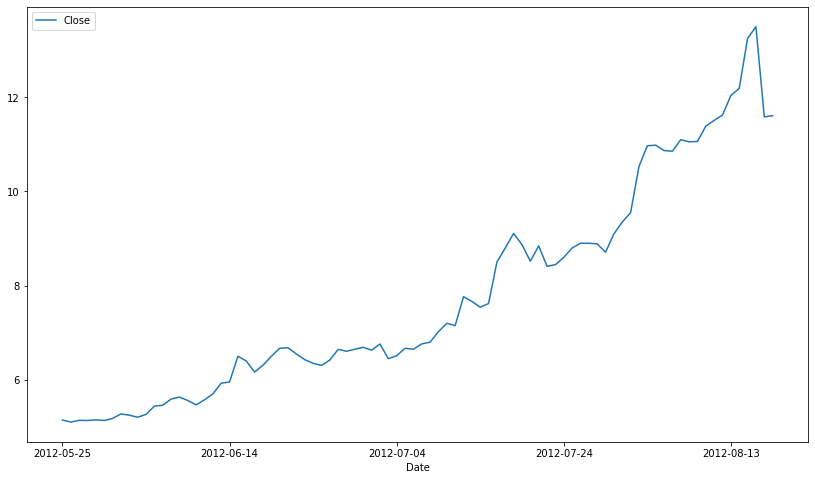

In [13]:
graph_lppl_model(starts[0], ends[0], CURRENCY)

BTC prices from 2013-01-03 to 2013-04-11 FIT TO LPPLS


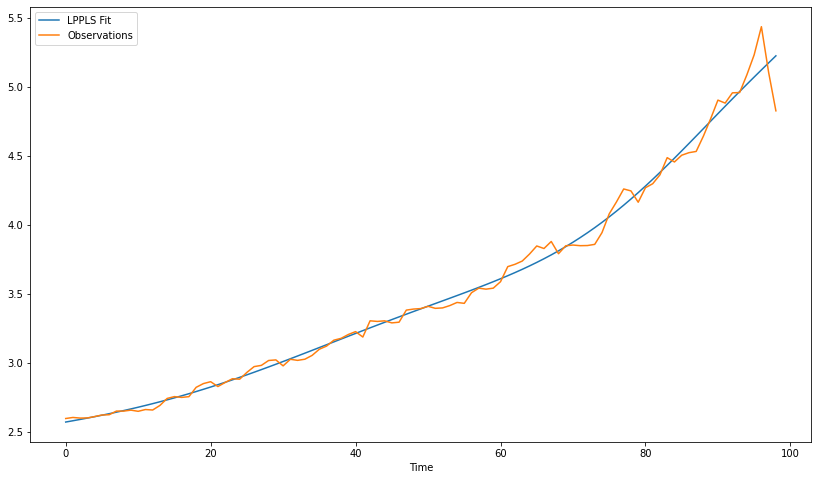

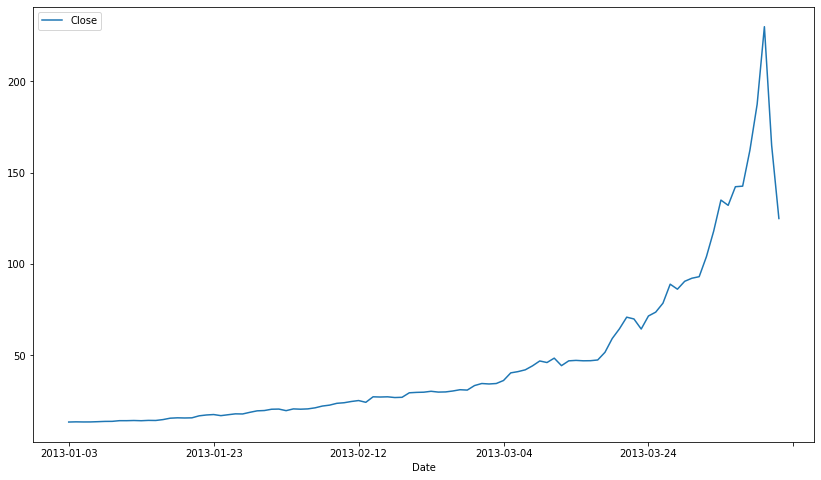

In [14]:
graph_lppl_model(starts[1], ends[1], CURRENCY)

BTC prices from 2013-10-07 to 2013-11-23 FIT TO LPPLS


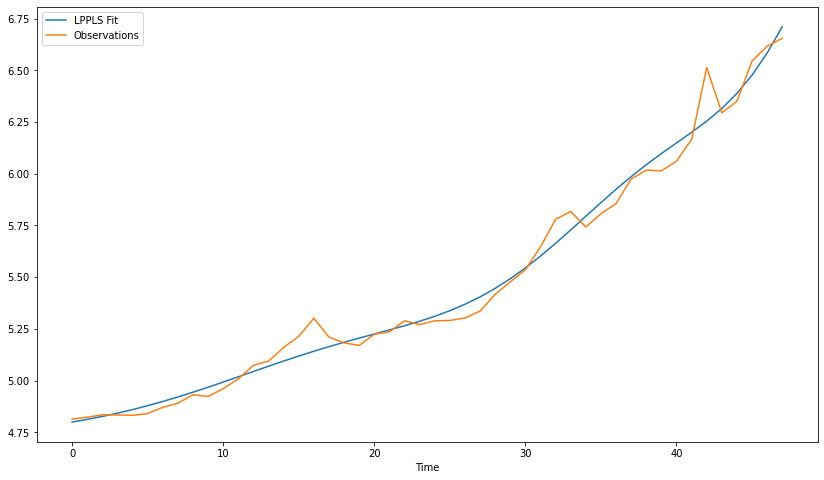

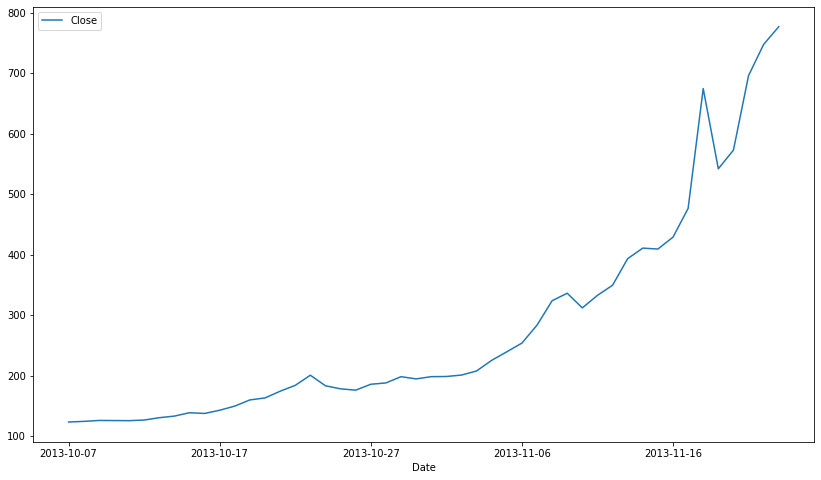

In [15]:
graph_lppl_model(starts[2], ends[2], CURRENCY)

BTC prices from 2015-06-08 to 2017-12-18 FIT TO LPPLS


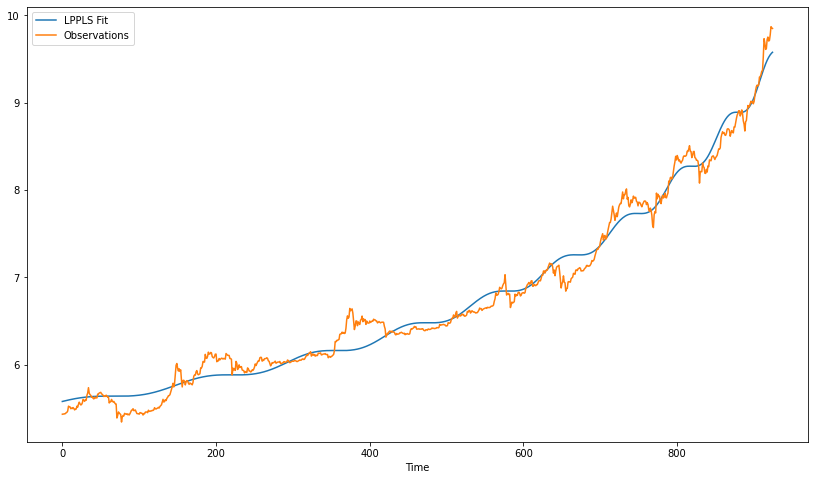

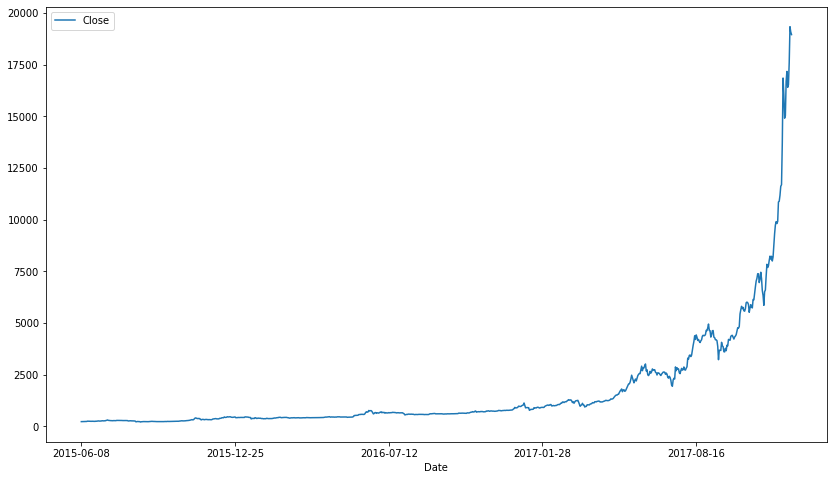

In [16]:
graph_lppl_model(starts[3], ends[3], CURRENCY)

BTC prices from 2017-03-31 to 2017-12-18 FIT TO LPPLS


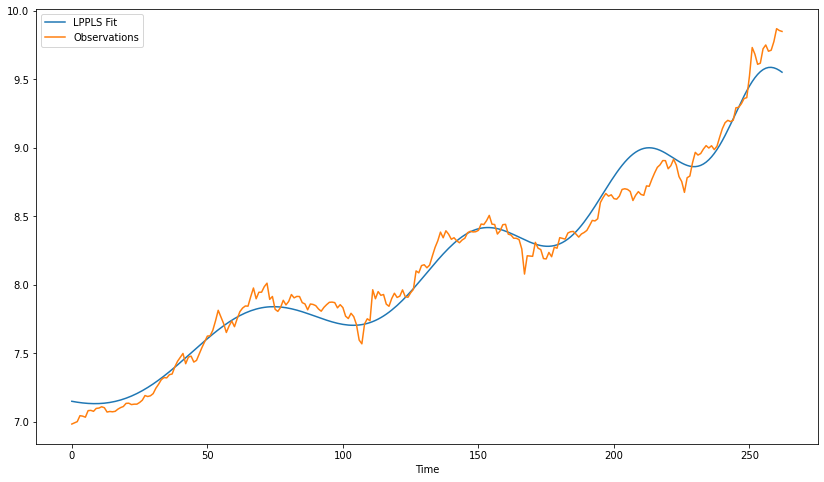

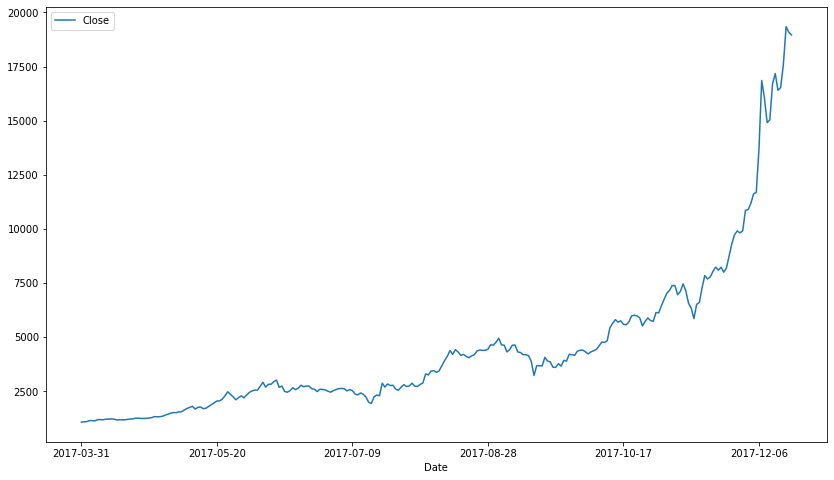

In [17]:
graph_lppl_model(starts[4], ends[4], CURRENCY)

BTC prices from 2017-12-18 to 2021-05-16 FIT TO LPPLS


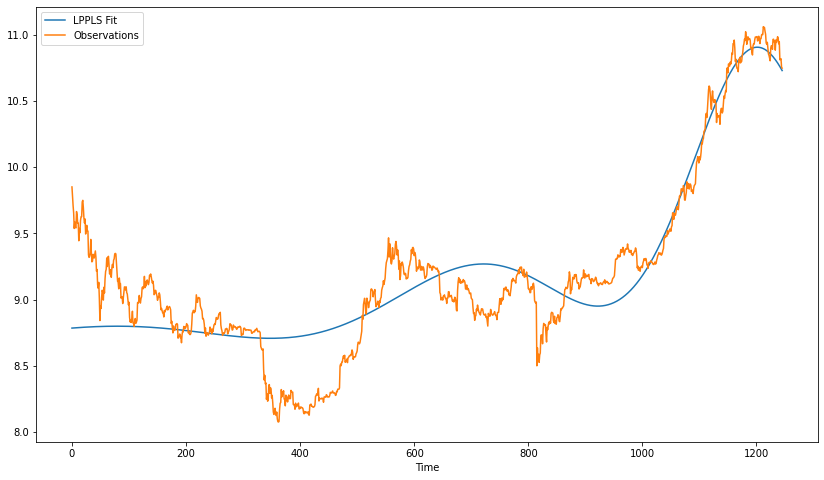

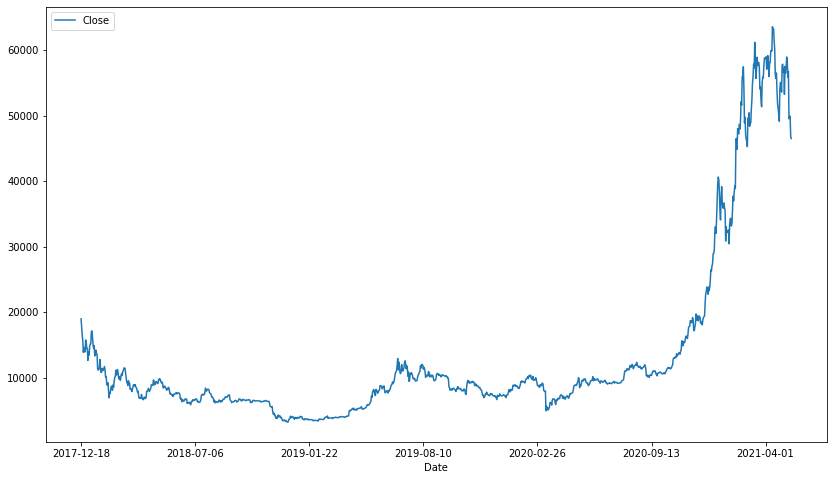

In [18]:
graph_lppl_model(starts[5], ends[5], CURRENCY)